<a href="https://colab.research.google.com/github/asu2304/Face_recognition_using_siamese_network/blob/main/deep_face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [24]:
POS_PATH = "/content/sample_data/positive"
NEG_PATH = "/content/sample_data/negative"
ANC_PATH = "/content/sample_data/anchor"

In [26]:
# os.getcwd()
# /content/sample_data/anchor

In [21]:
import tensorflow as tf

In [35]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [36]:
def preprocess(file_path):

    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0

    return img

In [37]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [38]:
sample = data.as_numpy_iterator()

In [39]:
eg = sample.next()
eg

(b'/content/sample_data/anchor/461bcb07-2bb9-11ee-ac0d-204ef6489e9c.jpg',
 b'/content/sample_data/positive/810acd42-2bba-11ee-b148-204ef6489e9c.jpg',
 1.0)

In [40]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img) , preprocess(validation_img) , label)

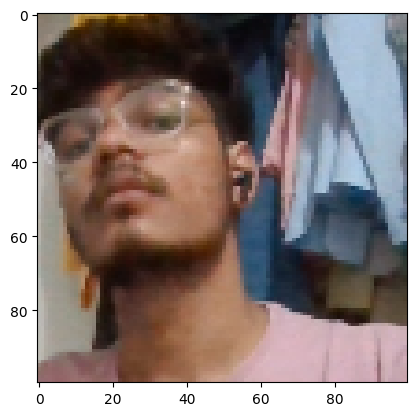

In [41]:
# preprocess_twin(*eg)
res = preprocess_twin(*eg)
plt.imshow(res[0])

In [42]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [43]:
# training partitian
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

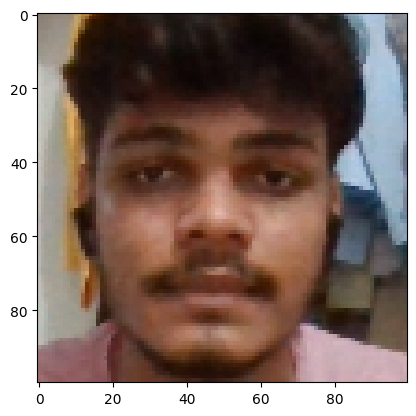

In [44]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
plt.imshow(train_sample[0][6])

In [45]:
#  we have batch of 16
len(train_sample[0])

16

In [46]:
# testing partitian
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)
# test_data = data.take(round(len(data)*0.3)) # no sense writing it

In [47]:
def make_embedding():

    # first block
    inp = Input(shape = (100, 100, 3), name = 'input_image')
    c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding = 'same')(c1)

    # second block
    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding = 'same')(c2)

    # third block
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding = 'same')(c3)

    # fouth layer
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)

    return Model(inputs = [inp], outputs = [d1], name = 'embedding')


In [48]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [49]:
# will create a custom nn layer
class L1Dist(Layer):

    def __init__(self, **kwargs):
        super().__init__()

    # the crux of the paper lies here(charaterstics of the siamese nn)!
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)



In [50]:
l1 = L1Dist()
l1

In [51]:
def make_siamese_model():

    input_image = Input(name = 'input_img', shape = (100, 100, 3))
    validation_image = Input(name = 'validation_img', shape = (100, 100, 3))

    siamese_layer = L1Dist(name = 'distance')
#     siamese_layer.name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # final classification layer
    classifier = Dense(1, activation = 'sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [52]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [53]:
binary_cross_loss = tf.losses.BinaryCrossentropy() # recommended set logits = true when the data is not standerizer
opt = tf.keras.optimizers.Adam(1e-4)

In [59]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoints = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [60]:
test_batch = test_data.as_numpy_iterator().next()
len(test_batch)

# understanding the data

# np.array(test_batch).shape
# x = test_batch[:2]
# np.array(x).shape
# len(test_batch[1])

# np.array(sample[0]).shape
# len(sample[0][0][0][0])

3

In [61]:
@tf.function # this line will make the follwing function will integrate the following function to be a computational grpah!
def train_step(batch):

    # recording all of our operations
    with tf.GradientTape() as tape:

        # getting anchor and positive images
        X = batch[:2]
        y = batch[2]

        # forward pass
        yhat = siamese_model(X, training = True) # setting training = true madetory for training
        # calculate loss
        loss = binary_cross_loss(y, yhat)

    print(loss)

    # calculating gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # calcualtes updated weights and apply to the siamese network
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [62]:
def train(data, EPOCHS):

    for epoch in range(1, EPOCHS + 1):

        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data)) # to inculcate the progression!

        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx + 1)

        if epoch % 10 == 0:
            checkpoints.save(file_prefix = checkpoint_prefix)

In [63]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 6s 210ms/step

 Epoch 2/50
27/27 [==============================] - 5s 189ms/step

 Epoch 3/50
27/27 [==============================] - 5s 190ms/step

 Epoch 4/50
27/27 [==============================] - 5s 191ms/step

 Epoch 5/50
27/27 [==============================] - 5s 192ms/step

 Epoch 6/50
27/27 [==============================] - 5s 192ms/step

 Epoch 7/50
27/27 [==============================] - 5s 193ms/step

 Epoch 8/50
27/27 [==============================] - 5s 192ms/step

 Epoch 9/50
27/27 [==============================] - 5s 192ms/step

 Epoch 10/50
27/27 [==============================] - 5s 191ms/step

 Epoch 11/50
27/27 [==============================] - 5s 190ms/step

 Epoch 12/50
27/27 [==============================] - 5s 190ms/step

 Epoch 13/50
27/27 [==============================] - 5s 189ms/step

 Epoch 14/50
27/27 [==============

In [64]:
from tensorflow.keras.metrics import Precision, Recall

In [65]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
test_var = test_data.as_numpy_iterator().next()
test_var

In [76]:
len(test_input[0])

100

In [79]:
siamese_model.save('siamese_model.h5')

In [ ]:
predictions